In [ ]:
import requests
import bs4
import os
import time
import numpy as np
import pickle
from itertools import product
import matplotlib.pyplot as plt
%matplotlib inline

Парсим отзывы на сайте areviews.ru. Были в ручную отобраны отзывы, которые близки к отзавам тестовой выборки http://areviews.ru/products/htc_wildfire_s/reviews
http://areviews.ru/products/nokia_asha_200/reviews
http://areviews.ru/products/htc_windows_phone_8s/reviews
http://areviews.ru/products/lg_l80_d380/reviews

In [84]:
%%time
# review parsing price&reviews
# Счетчик отзывов
counter = 0
# Загружаем отобранные ссылки из файла
with open("./products/areviews_links.txt") as links_file:
    for link in links_file:
        # На всякий случай делаем случайную задержку перед каждым парсингом
        t_sleep = np.random.randint(1, 100)*0.01
        time.sleep(t_sleep)
        # читаем данные по ссылке
        req = requests.get(link)
        link_parser = bs4.BeautifulSoup(req.text, 'lxml')
        # Находим все отзывы на странцие
        reviews_parser = link_parser.find('ul', attrs={'class', 'comment_list'})
        # Парсим следующий отзыв
        review_parser = reviews_parser.findAll('li')
        for review in review_parser:
            # Находим заголовок отзыва и извлекаем из него рейтинг, который был поставлен товару
            comment_header = review.find('div', attrs={'class', 'comment_header'})
            if not comment_header:
                continue
            rating = 5 - len(comment_header.findAll('i', attrs={'class', 'empty-star'}))
            # Находим текст отзыва, выделяем Достоинства, Недостатки и Комментарий
            review_parts = review.findAll('p')
            for res in review_parts:
                counter += 1
                if res.findChild('b').text == u"Достоинства:":
                    # Рассматриваем отмеченные достоинства как отдельный положительный отзыв
                    # Записываем его в папку ./pos
                    with open("./products/areviews/pos/"+str(counter)+".txt", 'w') as fid:
                        fid.write(res.text[12:].strip().lower().encode('utf8'))
                if res.findChild('b').text == u"Недостатки:":
                    # Рассматриваем отмеченные недостатки как отдельный негативный отзыв
                    # Записываем его в папку ./neg
                    with open("./products/areviews/neg/"+str(counter)+".txt", 'w') as fid:
                        fid.write(res.text[11:].strip().lower().encode('utf8'))
                if res.findChild('b').text == u"Комментарий:":
                    # Рассматриваемый комментарий как отдельный отзыв
                    # Записываем его в папку ./rating/[1-5] в зависимости от рейтинга
                    with open("./products/areviews/rating/"+str(rating)+"/"+str(counter)+".txt", 'w') as fid:
                        fid.write(res.text[12:].strip().lower().encode('utf8'))

In [106]:
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

Загружаем тестовые данные

In [135]:
with open("test1.csv", "r") as fid:
    text = fid.read()

In [139]:
parse_test = bs4.BeautifulSoup(text, 'lxml')
cnt = 0
data_test = []
for review in parse_test.findAll('review'):
    cnt += 1
    print cnt
    print review.text
    data_test.append(review.text)

1
Ужасно слабый аккумулятор, это основной минус этого аппарата, разряжается буквально за пару часов при включенном wifi и на макс подсветке, например если играть или смотреть видео, следовательно использовать можно только если есть постоянная возможность подзарядиться. Качества звука через динамик далеко не на высоте.Наблюдаются незначительные тормоза в некоторых приложениях и вообще в меню. Очень мало встроенной памяти, а приложения устанавливаются именно туда, с этим связанны неудобства - нужно постоянно переносить их на карту памяти.
Несколько неудобно что нету отдельной кнопки для фото. Подумываю купить батарею большей емкость мб что нибудь измениться.

2
ценанадежность-неубиваемостьдолго держит батарею 4 дня стабильно как телефон, 3-4 как плеер если 
постоянно долбиться в уши и звонить по паре часо на дню, игры и, конечно,  смс , в месяц около 200 шт набирается.
 Максимальное время работы 5 дней в щадящем режиме.2 simqwerty рулит -после нее набор смс на обычных сенсорниках и кнопо

Данные для обучения были составлены следующим образом: все отзывы в паапках neg (негативные отзывы) и pos (положительные отзывы) были перенесены соответственно в ./data/neg и ./data/pos, комментарии из папок ./rating/4, ./rating/5 были отнесены к ./data/pos, а комментарии из папок ./rating/neg и ./rating/1, ./rating/2 - в ./data/neg. Комментарии с рейтингом 3 никуда относить не будем, потому что там могут быть промежуточные отзывы, в которых есть как хвалеюные отзывы о продукте, так и негативные, а это может добавить шум в модель. Хотя те отзывы с рейтингом 3, которые я просматривал, были ближе к негативным.

In [109]:
data = load_files('./data', encoding='utf-8')

In [110]:
print "\nРазмер датасета: ", len(data.target)

# 0 - neg, 1 - pos
print "\nПример данных"
print "Label:", data.target[1]

print "Text:", data.data[1]

print "\nДоля положительных отзывов: ", data.target.mean()


Размер датасета:  2634

Пример данных
Label: 1
Text: крепкий
качественная сборка
функционален для своей цены
достаточно шустр, несмотря на старый процессор
компактный
внешний вид

Доля положительных отзывов:  0.526955201215


Построим какой-нибудь baseline. Например, будем использовать Tf-Idf векторизацию и логистическую регрессию.

In [111]:
%%time
pipe = Pipeline([('Vectorizer', TfidfVectorizer()), ('Classifier', LogisticRegression())])
scores = cross_val_score(pipe, data.data, data.target, cv=5)
print scores.mean()

0.894442175195
Wall time: 772 ms


Результат получился приемлемым, точность алгоритма (accuracy) больше 85% по оценке на кросс-валидации. Попробуем еще улучшить метод.

In [170]:
for vectorizer, classifier in product([CountVectorizer(), TfidfVectorizer()], 
                                      [LogisticRegression(), LinearSVC(), SGDClassifier()]):
    pipe = Pipeline([('Vectorizer', vectorizer), ('Classifier', classifier)])
    
    scores = cross_val_score(pipe, data.data, data.target, cv=5)
    print "###############################################"
    print "Vectorizer"
    print vectorizer
    print "Clasifier"
    print classifier
    print "CV score mean: %lf,std: %lf" % (scores.mean(), scores.std())
    print "###############################################"

###############################################
Vectorizer
CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern=u'(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)
Clasifier
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
CV score mean: 0.890269,std: 0.009769
###############################################
###############################################
Vectorizer
CountVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content

Лучше всего себя показал связка TfIdfVectorizer и LinearSVC, хотя изначально выбранная пара дает близкий результат к этой паре.

Попробуем подобрать оптимальные параметры min_df и max_df.

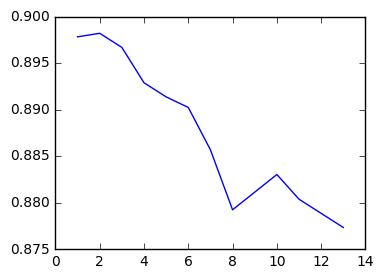

In [191]:
res_list = []
for m in range(1,14):
    pipe = Pipeline([('Vectorizer', TfidfVectorizer(min_df=m) ), ('Classifier', LinearSVC())])
    scores = cross_val_score(pipe, data.data, data.target, cv=5)
    res_list.append(scores.mean())
plt.figure(figsize=(4,3))
plt.plot(range(1,14), res_list)
plt.show()

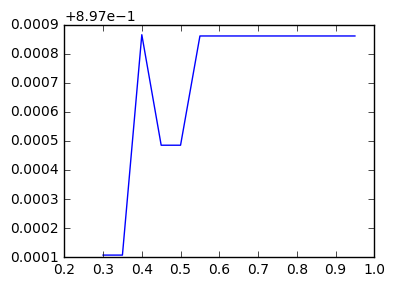

In [192]:
res_list = []
for m in np.arange(0.3, 1.0, 0.05):
    pipe = Pipeline([('Vectorizer', TfidfVectorizer(max_df=m) ), ('Classifier', LinearSVC())])
    scores = cross_val_score(pipe, data.data, data.target, cv=5)
    res_list.append(scores.mean())
plt.figure(figsize=(4,3))
plt.plot(np.arange(0.3, 1.0, 0.05), res_list)
plt.show()

Использование данных параметров не дает улучшения качетсва модели.

Попробуем использовать N-граммы.

In [194]:
pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(1,2)) ), ('Classifier', LinearSVC())])
scores = cross_val_score(pipe, data.data, data.target, cv=5)
scores.mean()

0.90393489989686981

In [196]:
pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(1,3)) ), ('Classifier', LinearSVC())])
scores = cross_val_score(pipe, data.data, data.target, cv=5)
scores.mean()

0.90317372486052727

In [197]:
pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(3,5), analyzer='char_wb') ), ('Classifier', LinearSVC())])
scores = cross_val_score(pipe, data.data, data.target, cv=5)
scores.mean()

0.90013985261377061

In [198]:
pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(3,7), analyzer='char_wb') ), ('Classifier', LinearSVC())])
scores = cross_val_score(pipe, data.data, data.target, cv=5)
scores.mean()

0.90317374945696527

2-граммы показали себя лучше всего. Подберем теперь параметр C для LinearSVC.

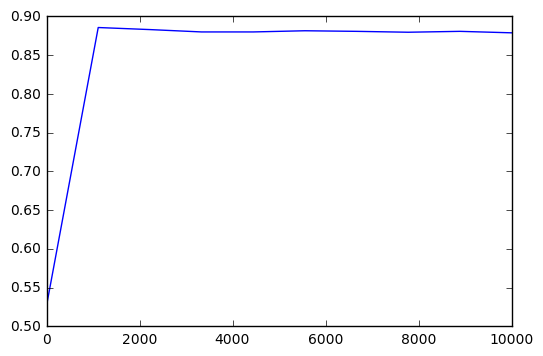

In [207]:
res_list = []
for C in np.linspace(1e-4,1e4,10):
    pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))), ('Classifier', LinearSVC(C=C))])
    scores = cross_val_score(pipe, data.data, data.target, cv=5)
    res_list.append(scores.mean())

plt.plot(np.linspace(1e-4,1e4,10), res_list)
plt.show()

In [208]:
print np.linspace(1e-4,1e4,10)[np.array(res_list).argmax()], np.array(res_list).max()

1111.1112 0.885703418774


1.21111111111 0.90355467176


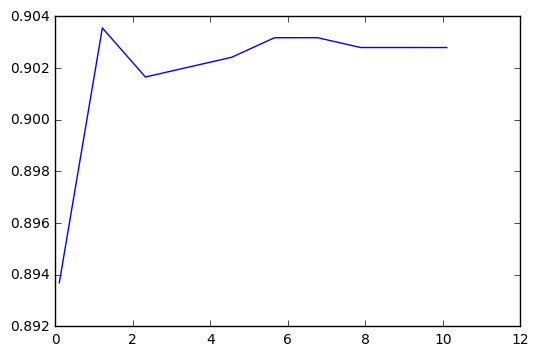

In [209]:
res_list = []
for C in np.linspace(0.1,10.1,10):
    pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))), ('Classifier', LinearSVC(C=C))])
    scores = cross_val_score(pipe, data.data, data.target, cv=5)
    res_list.append(scores.mean())
    
print np.linspace(0.1,10.1,10)[np.array(res_list).argmax()], np.array(res_list).max()
plt.plot(np.linspace(0.1,10.1,10), res_list)
plt.show()

0.534482758621 0.904310085764


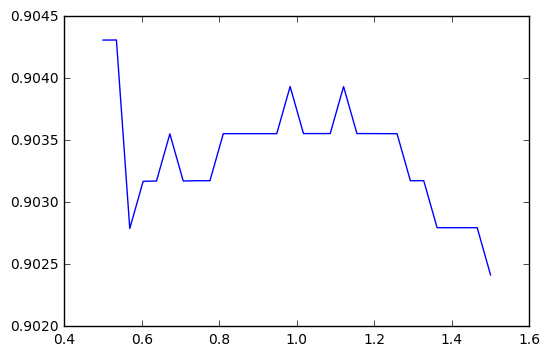

In [210]:
res_list = []
for C in np.linspace(0.5,1.5,30):
    pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))), ('Classifier', LinearSVC(C=C))])
    scores = cross_val_score(pipe, data.data, data.target, cv=5)
    res_list.append(scores.mean())
    
C = np.linspace(0.5,1.5,30)[np.array(res_list).argmax()] 
print C, np.array(res_list).max()
plt.plot(np.linspace(0.5,1.5,30), res_list)
plt.show()

Качество немного улучшилось. Критерий заказчика выполняется: оценка accuracy на кросс-валидации больше 85% и составляет 90.4%.

Обучим модель с оптимальными параметрами.

In [211]:
pipe = Pipeline([('Vectorizer', TfidfVectorizer(ngram_range=(1,2))), ('Classifier', LinearSVC(C=C))])

In [212]:
pipe.fit(data.data, data.target)

Pipeline(steps=[('Vectorizer', TfidfVectorizer(analyzer=u'word', binary=False, decode_error=u'strict',
        dtype=<type 'numpy.int64'>, encoding=u'utf-8', input=u'content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), norm=u'l2', preprocessor=None, smooth_id...    max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
     tol=0.0001, verbose=0))])

In [213]:
# Применяем на тестовых данных
predictions = pipe.predict(data_test)

Загружаем ручную разметку тестовых данных.

In [215]:
with open("./products/labels.txt", 'r') as fid:
    labels = map(int, fid.read().split('\n'))

In [216]:
from sklearn.metrics import accuracy_score

In [217]:
labels[:6]

[0, 1, 0, 0, 1, 1]

Проверяем качество модели на тестовых данных.

In [218]:
accuracy_score(labels, predictions)

0.97999999999999998

Все хорошо, на тесте тоже получили хорошее качество. Загружаем предсказания на kaggle.

In [219]:
pred_df = pd.DataFrame(predictions, columns=['y'])
pred_df.index.name = 'Id'
pred_df.replace(0, 'neg', inplace=True)
pred_df.replace(1, 'pos', inplace=True)
pred_df.to_csv('predictions.csv', sep=',')

Получили оценку 1.0, так как там используется только половина тестовых данных.

Ссылка на submission: https://inclass.kaggle.com/c/product-reviews-sentiment-analysis/leaderboard?submissionId=4301091